In this project, we will use a support vector machine (SVM) to predict whether an individual's annual income exceeds $50,000 given attributes about their educational and ethnic background, working class, and a few other features provided in [this](https://archive.ics.uci.edu/ml/datasets/adult) dataset from the UCI Machine Learning Repository.

Here, the preliminary data analysis will proceed the same as in `IncomeViaLogisticRegression.ipynb`, except that we will use KNN imputation to impute missing values rather than treating them as their own category.

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

First, we import the data.

In [119]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', \
        'marital-status', 'occupation', 'relationship', 'race', 'sex', \
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', \
        'income']
df_orig = pd.read_csv('adult.data', names=cols, index_col=False, sep=', ', engine='python')
df = df_orig.copy()
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


It is worth noting the missing values in some of the variables, denoted by a '?'.

In [120]:
print('Number of missing values for each variable:')
for col in df:
    vc = df[col].value_counts()
    num_missing = 0
    if '?' in vc.index:
        num_missing = vc['?']
    print('  ', col, ':', num_missing)

Number of missing values for each variable:
   age : 0
   workclass : 1836
   fnlwgt : 0
   education : 0
   education-num : 0
   marital-status : 0
   occupation : 1843
   relationship : 0
   race : 0
   sex : 0
   capital-gain : 0
   capital-loss : 0
   hours-per-week : 0
   native-country : 583
   income : 0


There are a number of ways of dealing with this issue. The simplest method is to drop all observations with missing values. However, this is not ideal as we are losing valuable data in the other variables associated with the dropped observations. For continuous variables, a common technique is to replace the missing values with a logical/unimpeding guess. Depending on the situation, this is usually either a zero, one, or the mean or median of the rest of the values for that variable. A more advanced way of filling the missing values is to employ a technique called KNN imputation. In this technique, the observations with no missing values are used as training data to train a k-nearest neighbours algorithm, which predicts the missing values. This can be easily implemented using `sklearn`'s `impute.KNNImputer` class.

Some of the variables may require some explanation. `fnlwgt` is the final weight, which is the number of people the census believes this entry represents. For simplicity of analysis, and since it is more a quality of the population than the individual, this variable will be dropped. The variable `education-num` is an ordinal encoding of the `education` variable. The ordinal encoding will be more useful for our classification algorithm, so the education column will be removed. `relationship` represents the respondents' role in the family, which can be assessed from gender and marital status, so it, too, will be discarded. `capital-gain` and `capital-loss` represent income from sources other than wage or salary, such as investment income.

In [121]:
df = df.drop(['education', 'relationship', 'fnlwgt'], axis=1)

The variable `workclass` stands for the industry in which the responding unit is employed.

In [122]:
df.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

There are two small classes: `Without-pay` and `Never-worked`. I will combine these into a category called `Other`.  To simplify the analysis, we can group those who work for the government into a `Government` class, and both self-employed classes, incorporated and not incorporated, into a single one. `?` values will also be converted to `np.nan` to aid in later analysis.

In [123]:
df.workclass = df.workclass.map({'?':np.nan, 'Without-pay':'Other', 'Never-worked':'Other',\
                                 'Local-gov':'Government', 'State-gov':'Government', 'Federal-gov':'Government',\
                                 'Self-emp-not-inc':'Self-employed', 'Self-emp-inc':'Self-employed',\
                                 'Private':'Private'})
df.workclass.value_counts()

Private          22696
Government        4351
Self-employed     3657
Other               21
Name: workclass, dtype: int64

To investigate the distribution of the `workclass` variable and its relationship with our target variable `income`, we can plot a bar plot of the `workclass` variable, coloured by `income`. 

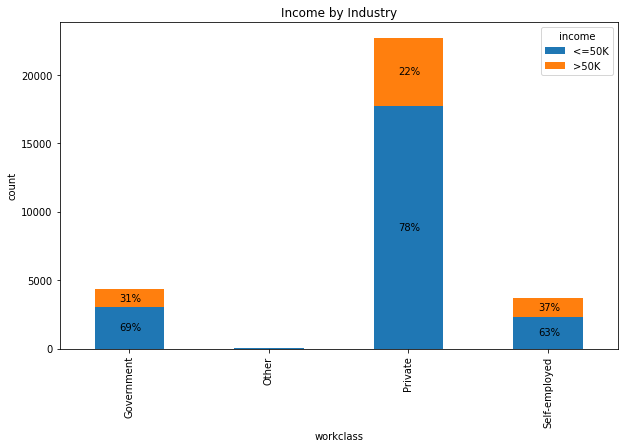

In [124]:
df_plot = df.groupby(['workclass', 'income']).size().reset_index().pivot(columns='income', \
                                                                         index='workclass', values=0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Income by Industry')
plt.ylabel('count')

annotations = df_plot.divide(df_plot.sum(axis=1), axis='index')
annotations = np.array(100*annotations).round().astype(int)
annotations = annotations.flatten(order='F')
for i, p in enumerate(ax.patches):
    ax.annotate(str(annotations[i]) + '%', (p.get_x()+.18, p.get_y()+p.get_height()//2-200))

Those who are self employed have the greatest tendency of making more than $50,000 annually, while those with other or unknown employment have the lowest tendency.

We can create a similar plot for the `education-num` variable.

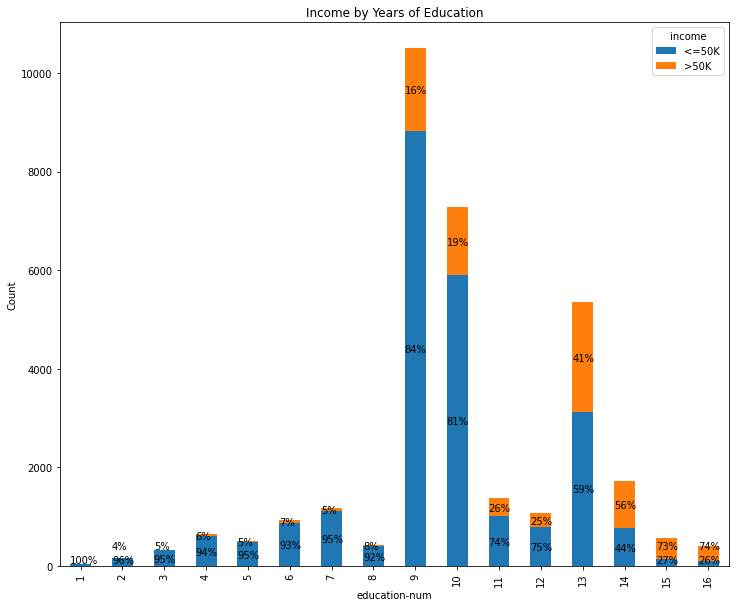

In [125]:
df_plot = df.groupby(['education-num', 'income']).size().reset_index().pivot(columns='income', \
                                                            index='education-num', values=0).fillna(0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(12,10))
plt.title('Income by Years of Education')
plt.ylabel('Count')

annotations = df_plot.divide(df_plot.sum(axis=1), axis='index')
annotations = np.array(100*annotations).round().astype(int)
annotations = annotations.flatten(order='F')
for i, p in enumerate(ax.patches):
    if annotations[i] == 0:
        continue
    x = p.get_x()
    y = max(p.get_y()+p.get_height()//2-80, 60)
    if i >= len(annotations)//2:
        y = max(y, 350)
        
    ax.annotate(str(annotations[i]) + '%', (x, y))

Perhaps unsuprisingly, the proportion of people making more than $\$$50,000 annually increases with years of education. Nearly three quarters of those with doctoral degrees (16) make more than $\$$50,000 per year, while less than 10% of those with a high school education (8) or less make over $\$$50,000 annually.

In [126]:
df.occupation.value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

To simplify the `occupation` variable, I will group together the given categories into `White-collar`, `Professional`, `Sales`, `Service`, `Blue-collar`, and `Armed-Forces` categories.  Again, `?` values will be converted to `np.nan`.

In [127]:
df.occupation = df.occupation.map({'Prof-specialty':'Professional', 'Craft-repair':'Blue-collar', \
                        'Exec-managerial':'White-collar', 'Adm-clerical':'White-collar', \
                        'Machine-op-inspct':'Blue-collar', 'Transport-moving':'Blue-collar', \
                        'Handlers-cleaners':'Blue-collar', 'Farming-fishing':'Blue-collar', \
                        'Other-service':'Service', 'Tech-support':'Service', 'Protective-serv':'Service', \
                        'Priv-house-serv':'Service', 'Sales':'Sales', \
                        '?':np.nan, 'Armed-Forces':'Armed-forces'})
df.occupation.value_counts()

Blue-collar     10062
White-collar     7836
Service          5021
Professional     4140
Sales            3650
Armed-forces        9
Name: occupation, dtype: int64

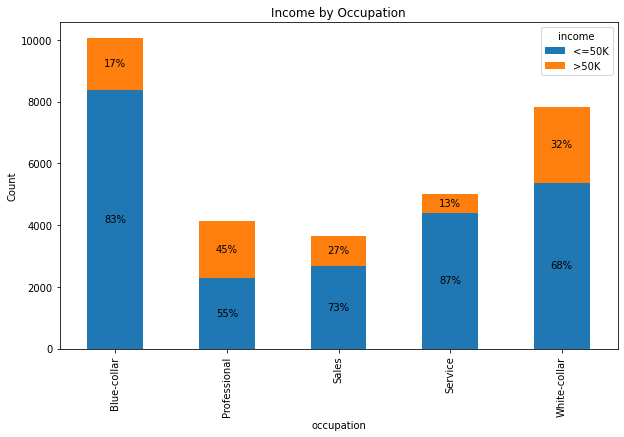

In [128]:
df_plot = df[df.occupation != 'Armed-forces'].groupby(['occupation', 'income']).size().reset_index()\
                                             .pivot(columns='income', index='occupation', values=0).fillna(0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Income by Occupation')
plt.ylabel('Count')

annotations = df_plot.divide(df_plot.sum(axis=1), axis='index')
annotations = np.array(100*annotations).round().astype(int)
annotations = annotations.flatten(order='F')
for i, p in enumerate(ax.patches):
    if annotations[i] == 0:
        continue
    x = p.get_x()+.15
    y = p.get_y()+p.get_height()//2-80
    if i >= len(annotations)//2:
        y = max(y, 350)
        
    ax.annotate(str(annotations[i]) + '%', (x, y))

It is notable that income varies greatly across different occupations.  Nearly half of those with a professional occupation make over $\$$50,000 annually, however only 13% of service workers make over $\$$50,000 per year.

The categorical `marital-status` variable will be simplified for analysis as well.

In [129]:
df['marital-status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

The `Married-civ-spouse`, `Married-spouse-absent`, and `Married-AF-spouse` categories will be combined into a `Married` variable.

In [130]:
df['marital-status'] = df['marital-status'].map({'Never-married':'Single', \
            'Married-civ-spouse':'Married', 'Married-spouse-absent':'Married', 'Married-AF-spouse':'Married', \
            'Divorced':'Divorced', 'Separated':'Separated', 'Widowed':'Widowed'})
df['marital-status'].value_counts()

Married      15417
Single       10683
Divorced      4443
Separated     1025
Widowed        993
Name: marital-status, dtype: int64

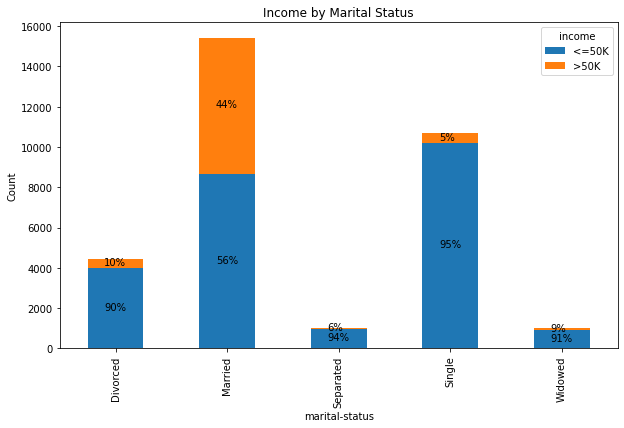

In [131]:
df_plot = df.groupby(['marital-status', 'income']).size().reset_index().pivot(columns='income', \
                                                            index='marital-status', values=0).fillna(0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Income by Marital Status')
plt.ylabel('Count')

annotations = df_plot.divide(df_plot.sum(axis=1), axis='index')
annotations = np.array(100*annotations).round().astype(int)
annotations = annotations.flatten(order='F')
for i, p in enumerate(ax.patches):
    if annotations[i] == 0:
        continue
    x = p.get_x()+.15
    y = p.get_y()+p.get_height()//2-80
    if i >= len(annotations)//2:
        y = max(y, 350)
        
    ax.annotate(str(annotations[i]) + '%', (x, y))

Almost half of married people make over $\$$50,000 annually, however, less than 10% of the rest of the respondents do.

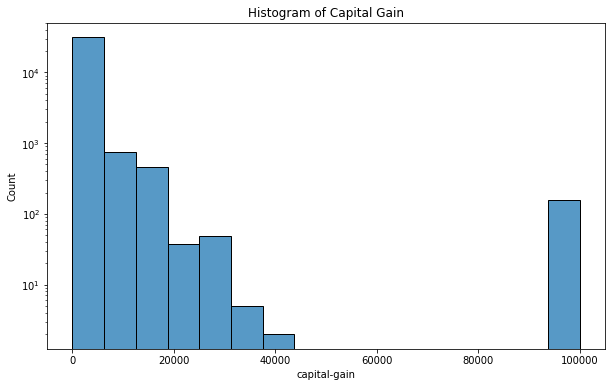

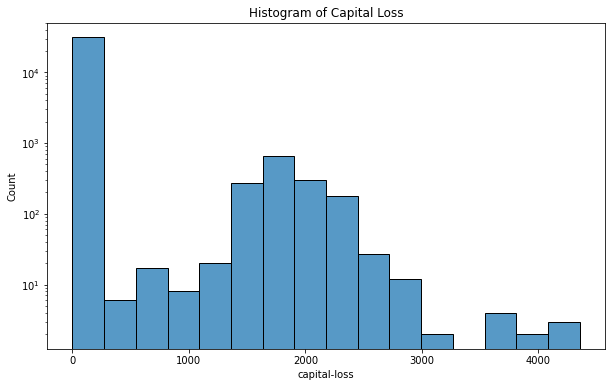

In [132]:
plt.figure(figsize=(10,6))
sns.histplot(df['capital-gain'])
plt.title('Histogram of Capital Gain')
plt.yscale('log')

plt.figure(figsize=(10,6))
sns.histplot(df['capital-loss'], label='capital loss')
plt.title('Histogram of Capital Loss')
plt.yscale('log')

In [133]:
print('Proportion of zeros [capital-gain]: %.1f%%' % (100*len(df[df['capital-gain'] == 0])/len(df)))
print('Proportion of zeros [capital-loss]: %.1f%%' % (100*len(df[df['capital-loss'] == 0])/len(df)))

Proportion of zeros [capital-gain]: 91.7%
Proportion of zeros [capital-loss]: 95.3%


As is clear from the above histograms (note the logarithmic scaling on the vertical axis) and computation, the `capital-gain` and `capital-loss` variables are both quite skewed, with a high proportion of zero values.  Thus, we will exclude them from the dataset.

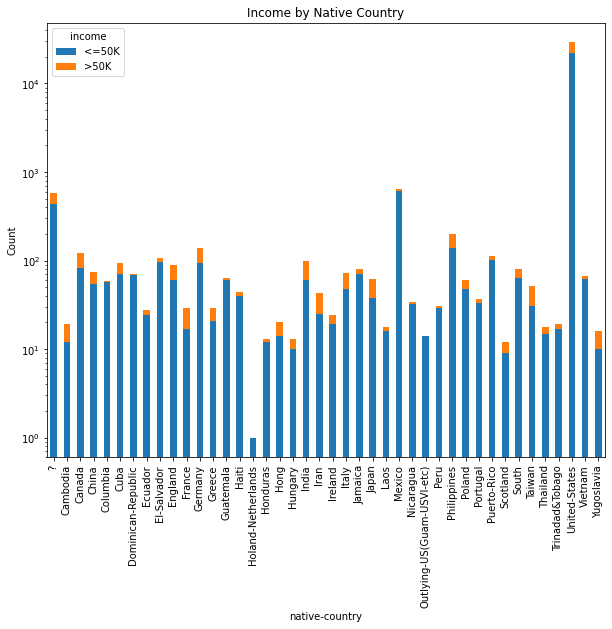

In [134]:
df_plot = df.groupby(['native-country', 'income']).size().reset_index().pivot(columns='income', \
                                                                index='native-country', values=0).fillna(0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(10,8))
plt.title('Income by Native Country')
plt.ylabel('Count')
plt.yscale('log')

Similarly, the `native-country` variable displays high skewness as most observations are from the United States (again, note the logarithmic scaling of the vertical axis on the above plot).  Hence, we will exclude this variable from our model as well.

In [135]:
df = df.drop(['capital-gain', 'capital-loss', 'native-country'], axis=1)

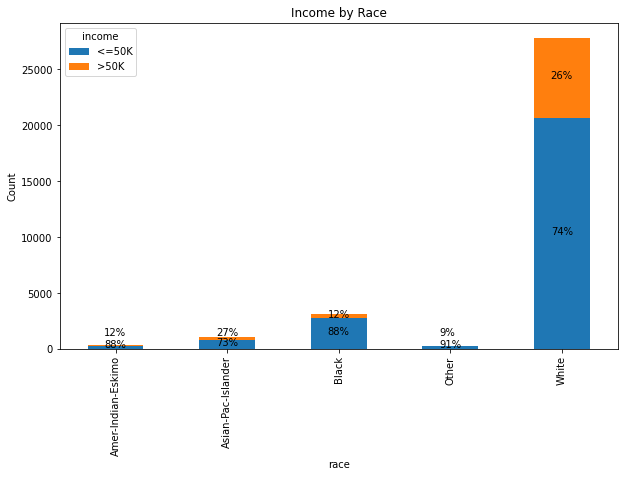

In [136]:
df_plot = df.groupby(['race', 'income']).size().reset_index().pivot(columns='income', \
                                                                    index='race', values=0).fillna(0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Income by Race')
plt.ylabel('Count')

annotations = df_plot.divide(df_plot.sum(axis=1), axis='index')
annotations = np.array(100*annotations).round().astype(int)
annotations = annotations.flatten(order='F')
for i, p in enumerate(ax.patches):
    if annotations[i] == 0:
        continue
    x = p.get_x()+.15
    y = max(p.get_y()+p.get_height()//2-80, 120)
    if i >= len(annotations)//2:
        y = max(y, 1200)
        
    ax.annotate(str(annotations[i]) + '%', (x, y))

From the above plot, we see that the majority of respondents are white, and that white and asian-pacific islanders have the largest proportions of individuals earning more than $\$$50,000 per year.

Text(0.5, 1.0, 'Superimposed Histograms of Age by Gender')

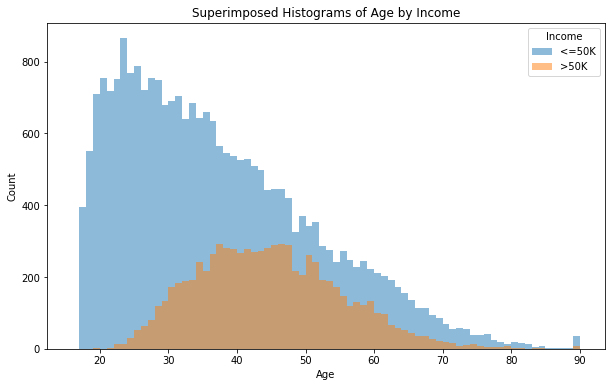

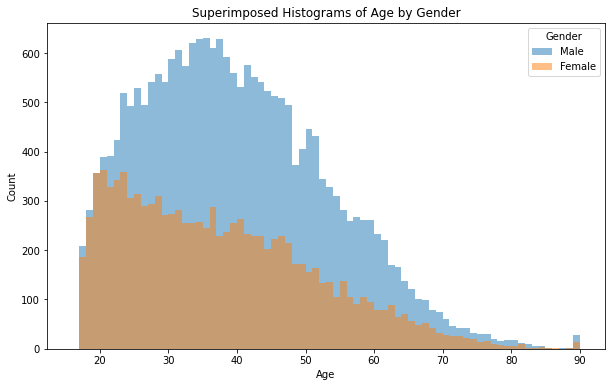

In [137]:
# Age hist by income
plt.figure(figsize=(10,6))
bins = np.linspace(min(df.age) - 1, max(df.age), max(df.age) - min(df.age) + 2)

plt.hist(df.age[df.income == '<=50K'], bins, alpha=0.5, label='<=50K')
plt.hist(df.age[df.income == '>50K'], bins, alpha=0.5, label='>50K')
plt.legend(loc='upper right', title='Income')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Superimposed Histograms of Age by Income')

# Age hist by gender
plt.figure(figsize=(10,6))
bins = np.linspace(min(df.age) - 1, max(df.age), max(df.age) - min(df.age) + 2)

plt.hist(df.age[df.sex == 'Male'], bins, alpha=0.5, label='Male')
plt.hist(df.age[df.sex == 'Female'], bins, alpha=0.5, label='Female')
plt.legend(loc='upper right', title='Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Superimposed Histograms of Age by Gender')

Inspecting the distribution of the age variable, we see that there are significantly more observations for those who make less than $\$$50,000 annually than those who make more.  Moreover, those who make more than $50,000 annually tend to be in their mid-career.

Interestingly, females are underrepresented in the dataset, which could be caused by a census bias.

Text(0.5, 1.0, 'Distributions of Hours per Week by Income')

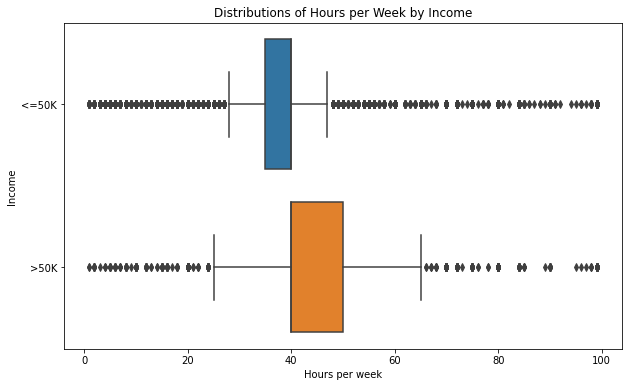

In [138]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='hours-per-week', y='income')

plt.xlabel('Hours per week')
plt.ylabel('Income')
plt.title('Distributions of Hours per Week by Income')

Unsuprisingly, we see that those who make more than $\$$50,000 annually tend to work more hours per week than those who make less. Also, it is notable that the distribution of hours worked has a larger spread for those who make more than $\$$50,000 per year than those who don't.

Now, we will process our data types to prepare the data for the SVM algorithm.  First, we convert our binary variables, `sex` and `income`, to integers.

In [139]:
df.sex = df.sex.map({'Male':0, 'Female':1})
df.income = df.income.map({'<=50K':0, '>50K':1})

Next, we will perform KNN imputation to impute the missing values in the `workclass` and `occupation` variables. We will do this using `sklearn`'s `impute.KNNImputer` class, but first we must transform our categorical data into numerical data. A simple ordinal encoding will suffice for this task. Later, we will reformat this ordinal encoding into a one-hot encoding, which will be better suited for the SVM.

In [140]:
ordinal_encodings = {}
for col in ['workclass', 'occupation', 'marital-status', 'race']:
    categories = df[col].unique()
    categories = categories[pd.notna(categories)]
    ordinals = range(len(categories))
    encoding = {a:b for a, b in zip(categories, ordinals)}
    encoding[np.nan] = np.nan
    df[col] = df[col].map(encoding)
    
    ordinal_encodings[col] = encoding

In [141]:
df.head()

,age,workclass,education-num,marital-status,occupation,race,sex,hours-per-week,income
0,39,0.0,13,0.0,0.0,0.0,0,40,0
1,50,1.0,13,1.0,0.0,0.0,0,13,0
2,38,2.0,9,2.0,1.0,0.0,0,40,0
3,53,2.0,7,1.0,1.0,1.0,0,40,0
4,28,2.0,13,1.0,2.0,1.0,1,40,0


Now that our data is all numerical, we can proceed with the imputation. KNN imputation trains a k-nearest neighbour algorithm to predict the missing data values. All observations without missing values are treated as training data, with the corresponding training labels being the non-missing values from the variable we are aiming to impute. The observations with a missing value are then used by the KNN algorithm to predict the missing values. 

A range of different regression algorithms can be used in place of the KNN, however KNN models have proven to be effective in experiments.

In our case, we must call the `round` method after the imputation since our data comes from an ordinal encoding, and thus must be an integer.

In [142]:
from sklearn.impute import KNNImputer

In [143]:
imputer = KNNImputer()
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns).round()

In [144]:
df.isna().any()

age               False
workclass         False
education-num     False
marital-status    False
occupation        False
race              False
sex               False
hours-per-week    False
income            False
dtype: bool

We now perform the ordinal encoding in reverse to transform our newly imputed variables back into strings. This is simply done to aid in retaining appropriate column names in the next step.

In [145]:
inverse_encodings = {v:{o:c for c, o in ordinal_encodings[v].items()} for v in ordinal_encodings}
for col in ['workclass', 'occupation', 'marital-status', 'race']:
    df[col] = df[col].map(inverse_encodings[col])

Next comes the one-hot encoding. When a logical order is not present in the features, as is the case in our categorical variables, a one-hot encoding is a common technique to quantify the categorical data. Here, each category is mapped to a vector containing a 1 or 0 to denote the presence or absence of a feature. For instance, our `marital-status` variable could represent 'Single' as $[0,1,0,0,0]$, where the vector entries correspond to 'Married', 'Single', 'Divorced', 'Separated', and 'Widowed' respectively. This method can cause issues for variables with large cardinality as it drastically increases the sparsity of the dataset, however, it is a good way to quantify our data. This method can be easily implemented with the `pandas` method `get_dummies`.

In [146]:
df = pd.get_dummies(df, columns=['workclass', 'marital-status', 'occupation', 'race'])
df.head()

,age,education-num,sex,hours-per-week,income,workclass_Government,workclass_Other,workclass_Private,workclass_Self-employed,marital-status_Divorced,...,occupation_Blue-collar,occupation_Professional,occupation_Sales,occupation_Service,occupation_White-collar,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39.0,13.0,0.0,40.0,0.0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,50.0,13.0,0.0,13.0,0.0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,38.0,9.0,0.0,40.0,0.0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
3,53.0,7.0,0.0,40.0,0.0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,28.0,13.0,1.0,40.0,0.0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


We will preform the regression with the machine learning library scikit-learn.

In [147]:
from sklearn.svm import SVC

The data is split into training and validation sets and the independent variables in both sets are standardized using the mean and standard deviation of the training dataset.

In [148]:
labels = df.income.copy()

data = df.drop('income', axis=1).copy()

train_frac = 0.75
train_len = int(train_frac * len(data))

train_msk = np.full(len(data), False)
train_msk[:train_len] = True
np.random.shuffle(train_msk)

train_data, train_labels = data[train_msk], labels[train_msk].to_numpy()
valid_data, valid_labels = data[~train_msk], labels[~train_msk].to_numpy()

#  Standardization
train_mean, train_std = train_data.mean(), train_data.std()
train_data = ((train_data - train_mean)/train_std).to_numpy()
valid_data = ((valid_data - train_mean)/train_std).to_numpy()

# Min-max normalization
# train_min, train_max = train_data.min(), train_data.max()
# train_data = ((train_data - train_min)/(train_max - train_min)).to_numpy()
# valid_data = ((valid_data - train_min)/(train_max - train_min)).to_numpy()

We will first start with the default parameters for our SVM.

In [149]:
classifier = SVC()
classifier.fit(train_data, train_labels)

SVC()

In [150]:
pred_labels = classifier.predict(valid_data)

In [151]:
valid_acc = (valid_labels == pred_labels).sum()/len(valid_labels)
print('Accuracy on validation data: %.2f%%' % (100*valid_acc))

Accuracy on validation data: 82.90%


A good start, however we may be able to improve on the accuracy by adjusting the regularization parameter $C$ and the $\gamma$ parameter of the Radial Basis Function kernel SVM. The parameter $C$ trades off correct classification of training examples against maximization of the decision function's margin.  For a larger $C$, a smaller margin will be accepted if the decision function is better at classifying training examples correctly.  A smaller $C$ will encourage a larger margin and may be more resistant to outliers, however it may decrease training accuracy.

The $\gamma$ parameter defines how far the infuence of each training example reaches, with lower values corresponging to a further reach.  A higher $\gamma$ will put more importance on the training data and could result in overfitting. Conversely, a lower $\gamma$ makes the points in the training data less relevant and can result in underfitting.

Here, we will use a logarithmic grid search over $C$ and $\gamma$ to find values which improve accuracy.

In [48]:
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV

In [36]:
C_range = np.logspace(1, 11, 11)
gamma_range = np.logspace(-11, -1, 11)

# Use a random tenth of the data to decrease computation times
frac = 0.1
msk = np.full(len(train_data), False)
msk[:int(len(train_data)*frac)] = True
np.random.shuffle(msk)

param_grid = dict(gamma=gamma_range, C=C_range)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=sss, verbose=99)
grid.fit(train_data[msk], train_labels[msk])

Fitting 5 folds for each of 121 candidates, totalling 605 fits
[CV 1/5; 1/121] START C=10.0, gamma=1e-11.......................................
[CV 1/5; 1/121] END ........C=10.0, gamma=1e-11;, score=0.759 total time=   0.2s
[CV 2/5; 1/121] START C=10.0, gamma=1e-11.......................................
[CV 2/5; 1/121] END ........C=10.0, gamma=1e-11;, score=0.759 total time=   0.2s
[CV 3/5; 1/121] START C=10.0, gamma=1e-11.......................................
[CV 3/5; 1/121] END ........C=10.0, gamma=1e-11;, score=0.759 total time=   0.1s
[CV 4/5; 1/121] START C=10.0, gamma=1e-11.......................................
[CV 4/5; 1/121] END ........C=10.0, gamma=1e-11;, score=0.759 total time=   0.1s
[CV 5/5; 1/121] START C=10.0, gamma=1e-11.......................................
[CV 5/5; 1/121] END ........C=10.0, gamma=1e-11;, score=0.759 total time=   0.1s
[CV 1/5; 2/121] START C=10.0, gamma=1e-10.......................................
[CV 1/5; 2/121] END ........C=10.0, gamma=1e-1

[CV 2/5; 11/121] END .........C=10.0, gamma=0.1;, score=0.812 total time=   0.2s
[CV 3/5; 11/121] START C=10.0, gamma=0.1........................................
[CV 3/5; 11/121] END .........C=10.0, gamma=0.1;, score=0.808 total time=   0.2s
[CV 4/5; 11/121] START C=10.0, gamma=0.1........................................
[CV 4/5; 11/121] END .........C=10.0, gamma=0.1;, score=0.812 total time=   0.2s
[CV 5/5; 11/121] START C=10.0, gamma=0.1........................................
[CV 5/5; 11/121] END .........C=10.0, gamma=0.1;, score=0.818 total time=   0.2s
[CV 1/5; 12/121] START C=100.0, gamma=1e-11.....................................
[CV 1/5; 12/121] END ......C=100.0, gamma=1e-11;, score=0.759 total time=   0.1s
[CV 2/5; 12/121] START C=100.0, gamma=1e-11.....................................
[CV 2/5; 12/121] END ......C=100.0, gamma=1e-11;, score=0.759 total time=   0.1s
[CV 3/5; 12/121] START C=100.0, gamma=1e-11.....................................
[CV 3/5; 12/121] END ......C

[CV 4/5; 21/121] END .......C=100.0, gamma=0.01;, score=0.816 total time=   0.2s
[CV 5/5; 21/121] START C=100.0, gamma=0.01......................................
[CV 5/5; 21/121] END .......C=100.0, gamma=0.01;, score=0.814 total time=   0.2s
[CV 1/5; 22/121] START C=100.0, gamma=0.1.......................................
[CV 1/5; 22/121] END ........C=100.0, gamma=0.1;, score=0.798 total time=   0.2s
[CV 2/5; 22/121] START C=100.0, gamma=0.1.......................................
[CV 2/5; 22/121] END ........C=100.0, gamma=0.1;, score=0.796 total time=   0.2s
[CV 3/5; 22/121] START C=100.0, gamma=0.1.......................................
[CV 3/5; 22/121] END ........C=100.0, gamma=0.1;, score=0.779 total time=   0.2s
[CV 4/5; 22/121] START C=100.0, gamma=0.1.......................................
[CV 4/5; 22/121] END ........C=100.0, gamma=0.1;, score=0.808 total time=   0.2s
[CV 5/5; 22/121] START C=100.0, gamma=0.1.......................................
[CV 5/5; 22/121] END .......

[CV 5/5; 31/121] END .....C=1000.0, gamma=0.001;, score=0.830 total time=   0.5s
[CV 1/5; 32/121] START C=1000.0, gamma=0.01.....................................
[CV 1/5; 32/121] END ......C=1000.0, gamma=0.01;, score=0.816 total time=   0.6s
[CV 2/5; 32/121] START C=1000.0, gamma=0.01.....................................
[CV 2/5; 32/121] END ......C=1000.0, gamma=0.01;, score=0.804 total time=   0.7s
[CV 3/5; 32/121] START C=1000.0, gamma=0.01.....................................
[CV 3/5; 32/121] END ......C=1000.0, gamma=0.01;, score=0.800 total time=   1.0s
[CV 4/5; 32/121] START C=1000.0, gamma=0.01.....................................
[CV 4/5; 32/121] END ......C=1000.0, gamma=0.01;, score=0.800 total time=   0.7s
[CV 5/5; 32/121] START C=1000.0, gamma=0.01.....................................
[CV 5/5; 32/121] END ......C=1000.0, gamma=0.01;, score=0.820 total time=   0.8s
[CV 1/5; 33/121] START C=1000.0, gamma=0.1......................................
[CV 1/5; 33/121] END .......

[CV 1/5; 42/121] END ....C=10000.0, gamma=0.001;, score=0.824 total time=   0.7s
[CV 2/5; 42/121] START C=10000.0, gamma=0.001...................................
[CV 2/5; 42/121] END ....C=10000.0, gamma=0.001;, score=0.832 total time=   0.7s
[CV 3/5; 42/121] START C=10000.0, gamma=0.001...................................
[CV 3/5; 42/121] END ....C=10000.0, gamma=0.001;, score=0.812 total time=   0.6s
[CV 4/5; 42/121] START C=10000.0, gamma=0.001...................................
[CV 4/5; 42/121] END ....C=10000.0, gamma=0.001;, score=0.828 total time=   0.7s
[CV 5/5; 42/121] START C=10000.0, gamma=0.001...................................
[CV 5/5; 42/121] END ....C=10000.0, gamma=0.001;, score=0.824 total time=   0.6s
[CV 1/5; 43/121] START C=10000.0, gamma=0.01....................................
[CV 1/5; 43/121] END .....C=10000.0, gamma=0.01;, score=0.806 total time=   2.8s
[CV 2/5; 43/121] START C=10000.0, gamma=0.01....................................
[CV 2/5; 43/121] END .....C=

[CV 2/5; 52/121] END ..C=100000.0, gamma=0.0001;, score=0.834 total time=   0.9s
[CV 3/5; 52/121] START C=100000.0, gamma=0.0001.................................
[CV 3/5; 52/121] END ..C=100000.0, gamma=0.0001;, score=0.818 total time=   1.1s
[CV 4/5; 52/121] START C=100000.0, gamma=0.0001.................................
[CV 4/5; 52/121] END ..C=100000.0, gamma=0.0001;, score=0.814 total time=   0.5s
[CV 5/5; 52/121] START C=100000.0, gamma=0.0001.................................
[CV 5/5; 52/121] END ..C=100000.0, gamma=0.0001;, score=0.828 total time=   0.6s
[CV 1/5; 53/121] START C=100000.0, gamma=0.001..................................
[CV 1/5; 53/121] END ...C=100000.0, gamma=0.001;, score=0.808 total time=   3.8s
[CV 2/5; 53/121] START C=100000.0, gamma=0.001..................................
[CV 2/5; 53/121] END ...C=100000.0, gamma=0.001;, score=0.814 total time=   3.2s
[CV 3/5; 53/121] START C=100000.0, gamma=0.001..................................
[CV 3/5; 53/121] END ...C=10

[CV 3/5; 62/121] END ..C=1000000.0, gamma=1e-05;, score=0.828 total time=   0.6s
[CV 4/5; 62/121] START C=1000000.0, gamma=1e-05.................................
[CV 4/5; 62/121] END ..C=1000000.0, gamma=1e-05;, score=0.816 total time=   0.7s
[CV 5/5; 62/121] START C=1000000.0, gamma=1e-05.................................
[CV 5/5; 62/121] END ..C=1000000.0, gamma=1e-05;, score=0.832 total time=   0.7s
[CV 1/5; 63/121] START C=1000000.0, gamma=0.0001................................
[CV 1/5; 63/121] END .C=1000000.0, gamma=0.0001;, score=0.814 total time=   6.2s
[CV 2/5; 63/121] START C=1000000.0, gamma=0.0001................................
[CV 2/5; 63/121] END .C=1000000.0, gamma=0.0001;, score=0.830 total time=   8.2s
[CV 3/5; 63/121] START C=1000000.0, gamma=0.0001................................
[CV 3/5; 63/121] END .C=1000000.0, gamma=0.0001;, score=0.808 total time=   6.2s
[CV 4/5; 63/121] START C=1000000.0, gamma=0.0001................................
[CV 4/5; 63/121] END .C=1000

[CV 4/5; 72/121] END .C=10000000.0, gamma=1e-06;, score=0.810 total time=   0.2s
[CV 5/5; 72/121] START C=10000000.0, gamma=1e-06................................
[CV 5/5; 72/121] END .C=10000000.0, gamma=1e-06;, score=0.828 total time=   0.2s
[CV 1/5; 73/121] START C=10000000.0, gamma=1e-05................................
[CV 1/5; 73/121] END .C=10000000.0, gamma=1e-05;, score=0.814 total time=   1.1s
[CV 2/5; 73/121] START C=10000000.0, gamma=1e-05................................
[CV 2/5; 73/121] END .C=10000000.0, gamma=1e-05;, score=0.832 total time=   1.4s
[CV 3/5; 73/121] START C=10000000.0, gamma=1e-05................................
[CV 3/5; 73/121] END .C=10000000.0, gamma=1e-05;, score=0.816 total time=   0.9s
[CV 4/5; 73/121] START C=10000000.0, gamma=1e-05................................
[CV 4/5; 73/121] END .C=10000000.0, gamma=1e-05;, score=0.828 total time=   1.1s
[CV 5/5; 73/121] START C=10000000.0, gamma=1e-05................................
[CV 5/5; 73/121] END .C=1000

[CV 5/5; 82/121] END C=100000000.0, gamma=1e-07;, score=0.818 total time=   0.2s
[CV 1/5; 83/121] START C=100000000.0, gamma=1e-06...............................
[CV 1/5; 83/121] END C=100000000.0, gamma=1e-06;, score=0.818 total time=   0.3s
[CV 2/5; 83/121] START C=100000000.0, gamma=1e-06...............................
[CV 2/5; 83/121] END C=100000000.0, gamma=1e-06;, score=0.845 total time=   0.3s
[CV 3/5; 83/121] START C=100000000.0, gamma=1e-06...............................
[CV 3/5; 83/121] END C=100000000.0, gamma=1e-06;, score=0.808 total time=   0.3s
[CV 4/5; 83/121] START C=100000000.0, gamma=1e-06...............................
[CV 4/5; 83/121] END C=100000000.0, gamma=1e-06;, score=0.810 total time=   0.2s
[CV 5/5; 83/121] START C=100000000.0, gamma=1e-06...............................
[CV 5/5; 83/121] END C=100000000.0, gamma=1e-06;, score=0.826 total time=   0.2s
[CV 1/5; 84/121] START C=100000000.0, gamma=1e-05...............................
[CV 1/5; 84/121] END C=10000

[CV 2/5; 93/121] END C=1000000000.0, gamma=1e-07;, score=0.840 total time=   0.1s
[CV 3/5; 93/121] START C=1000000000.0, gamma=1e-07..............................
[CV 3/5; 93/121] END C=1000000000.0, gamma=1e-07;, score=0.810 total time=   0.1s
[CV 4/5; 93/121] START C=1000000000.0, gamma=1e-07..............................
[CV 4/5; 93/121] END C=1000000000.0, gamma=1e-07;, score=0.814 total time=   0.1s
[CV 5/5; 93/121] START C=1000000000.0, gamma=1e-07..............................
[CV 5/5; 93/121] END C=1000000000.0, gamma=1e-07;, score=0.822 total time=   0.1s
[CV 1/5; 94/121] START C=1000000000.0, gamma=1e-06..............................
[CV 1/5; 94/121] END C=1000000000.0, gamma=1e-06;, score=0.822 total time=   0.3s
[CV 2/5; 94/121] START C=1000000000.0, gamma=1e-06..............................
[CV 2/5; 94/121] END C=1000000000.0, gamma=1e-06;, score=0.849 total time=   0.2s
[CV 3/5; 94/121] START C=1000000000.0, gamma=1e-06..............................
[CV 3/5; 94/121] END C

[CV 4/5; 103/121] END C=10000000000.0, gamma=1e-08;, score=0.814 total time=   0.1s
[CV 5/5; 103/121] START C=10000000000.0, gamma=1e-08............................
[CV 5/5; 103/121] END C=10000000000.0, gamma=1e-08;, score=0.812 total time=   0.1s
[CV 1/5; 104/121] START C=10000000000.0, gamma=1e-07............................
[CV 1/5; 104/121] END C=10000000000.0, gamma=1e-07;, score=0.800 total time=   0.2s
[CV 2/5; 104/121] START C=10000000000.0, gamma=1e-07............................
[CV 2/5; 104/121] END C=10000000000.0, gamma=1e-07;, score=0.840 total time=   0.1s
[CV 3/5; 104/121] START C=10000000000.0, gamma=1e-07............................
[CV 3/5; 104/121] END C=10000000000.0, gamma=1e-07;, score=0.816 total time=   0.1s
[CV 4/5; 104/121] START C=10000000000.0, gamma=1e-07............................
[CV 4/5; 104/121] END C=10000000000.0, gamma=1e-07;, score=0.800 total time=   0.1s
[CV 5/5; 104/121] START C=10000000000.0, gamma=1e-07............................
[CV 5/5; 1

[CV 5/5; 113/121] END C=100000000000.0, gamma=1e-09;, score=0.759 total time=   0.1s
[CV 1/5; 114/121] START C=100000000000.0, gamma=1e-08...........................
[CV 1/5; 114/121] END C=100000000000.0, gamma=1e-08;, score=0.806 total time=   0.1s
[CV 2/5; 114/121] START C=100000000000.0, gamma=1e-08...........................
[CV 2/5; 114/121] END C=100000000000.0, gamma=1e-08;, score=0.816 total time=   0.1s
[CV 3/5; 114/121] START C=100000000000.0, gamma=1e-08...........................
[CV 3/5; 114/121] END C=100000000000.0, gamma=1e-08;, score=0.810 total time=   0.1s
[CV 4/5; 114/121] START C=100000000000.0, gamma=1e-08...........................
[CV 4/5; 114/121] END C=100000000000.0, gamma=1e-08;, score=0.820 total time=   0.1s
[CV 5/5; 114/121] START C=100000000000.0, gamma=1e-08...........................
[CV 5/5; 114/121] END C=100000000000.0, gamma=1e-08;, score=0.812 total time=   0.1s
[CV 1/5; 115/121] START C=100000000000.0, gamma=1e-07...........................
[CV 

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08,
       1.e+09, 1.e+10, 1.e+11]),
                         'gamma': array([1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04,
       1.e-03, 1.e-02, 1.e-01])},
             verbose=99)

In [37]:
print('The best parameters are %s with a score of %0.2f' % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 100.0, 'gamma': 0.001} with a score of 0.83


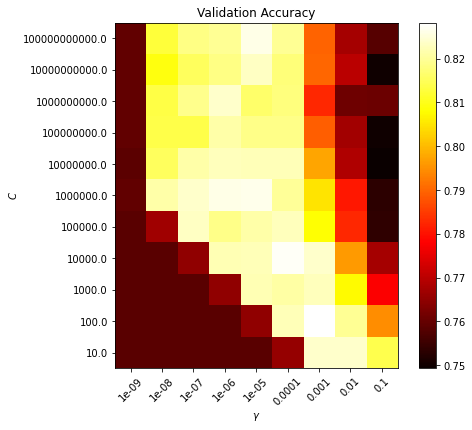

In [59]:
gamma_range_s = gamma_range[2:]
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))[:, 2:]

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, cmap=plt.cm.hot, origin='lower')
plt.xlabel('$\gamma$')
plt.ylabel('$C$')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range_s)), gamma_range_s, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

We seem to obtain good results for a variety of parameter pairs. We will try a search with a finer grid to narrow down closer to optimal parameter values. It is clear from the plot that we obtain better results when the parameters fall on the downward diagonal of the plot. Since it is far more computationally expensive to train a SVM with a higher $C$ value than a lower one, we will focus on lower $C$ values and higher $\gamma$ values. Thus, we will search using a base 2 logarithmic grid for $C$ between $2^6$ and $2^{20}$ and $\gamma$ between $2^{-20}$ and $2^{-9}$.

In [61]:
## Same thing again with narrower, more specific range on C, gamma

In [66]:
C_range = np.logspace(6, 20, 15, base=2)
gamma_range = np.logspace(-20, -9, 12, base=2)

frac = 0.2
msk = np.full(len(train_data), False)
msk[:int(len(train_data)*frac)] = True
np.random.shuffle(msk)

param_grid = dict(gamma=gamma_range, C=C_range)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=sss, verbose=99)
grid.fit(train_data[msk], train_labels[msk])

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5; 1/180] START C=64.0, gamma=9.5367431640625e-07.........................
[CV 1/5; 1/180] END C=64.0, gamma=9.5367431640625e-07;, score=0.759 total time=   0.7s
[CV 2/5; 1/180] START C=64.0, gamma=9.5367431640625e-07.........................
[CV 2/5; 1/180] END C=64.0, gamma=9.5367431640625e-07;, score=0.759 total time=   0.6s
[CV 3/5; 1/180] START C=64.0, gamma=9.5367431640625e-07.........................
[CV 3/5; 1/180] END C=64.0, gamma=9.5367431640625e-07;, score=0.759 total time=   0.6s
[CV 4/5; 1/180] START C=64.0, gamma=9.5367431640625e-07.........................
[CV 4/5; 1/180] END C=64.0, gamma=9.5367431640625e-07;, score=0.759 total time=   0.6s
[CV 5/5; 1/180] START C=64.0, gamma=9.5367431640625e-07.........................
[CV 5/5; 1/180] END C=64.0, gamma=9.5367431640625e-07;, score=0.759 total time=   0.6s
[CV 1/5; 2/180] START C=64.0, gamma=1.9073486328125e-06.........................
[CV 1/5; 2/180] 

[CV 5/5; 10/180] END C=64.0, gamma=0.00048828125;, score=0.838 total time=   0.6s
[CV 1/5; 11/180] START C=64.0, gamma=0.0009765625...............................
[CV 1/5; 11/180] END C=64.0, gamma=0.0009765625;, score=0.831 total time=   0.6s
[CV 2/5; 11/180] START C=64.0, gamma=0.0009765625...............................
[CV 2/5; 11/180] END C=64.0, gamma=0.0009765625;, score=0.818 total time=   0.6s
[CV 3/5; 11/180] START C=64.0, gamma=0.0009765625...............................
[CV 3/5; 11/180] END C=64.0, gamma=0.0009765625;, score=0.838 total time=   0.7s
[CV 4/5; 11/180] START C=64.0, gamma=0.0009765625...............................
[CV 4/5; 11/180] END C=64.0, gamma=0.0009765625;, score=0.837 total time=   1.2s
[CV 5/5; 11/180] START C=64.0, gamma=0.0009765625...............................
[CV 5/5; 11/180] END C=64.0, gamma=0.0009765625;, score=0.843 total time=   0.9s
[CV 1/5; 12/180] START C=64.0, gamma=0.001953125................................
[CV 1/5; 12/180] END .C=64.

[CV 5/5; 20/180] END C=128.0, gamma=0.0001220703125;, score=0.840 total time=   1.0s
[CV 1/5; 21/180] START C=128.0, gamma=0.000244140625............................
[CV 1/5; 21/180] END C=128.0, gamma=0.000244140625;, score=0.828 total time=   0.8s
[CV 2/5; 21/180] START C=128.0, gamma=0.000244140625............................
[CV 2/5; 21/180] END C=128.0, gamma=0.000244140625;, score=0.810 total time=   0.8s
[CV 3/5; 21/180] START C=128.0, gamma=0.000244140625............................
[CV 3/5; 21/180] END C=128.0, gamma=0.000244140625;, score=0.835 total time=   0.7s
[CV 4/5; 21/180] START C=128.0, gamma=0.000244140625............................
[CV 4/5; 21/180] END C=128.0, gamma=0.000244140625;, score=0.836 total time=   0.6s
[CV 5/5; 21/180] START C=128.0, gamma=0.000244140625............................
[CV 5/5; 21/180] END C=128.0, gamma=0.000244140625;, score=0.837 total time=   0.6s
[CV 1/5; 22/180] START C=128.0, gamma=0.00048828125.............................
[CV 1/5; 

[CV 5/5; 30/180] END C=256.0, gamma=3.0517578125e-05;, score=0.836 total time=   0.9s
[CV 1/5; 31/180] START C=256.0, gamma=6.103515625e-05...........................
[CV 1/5; 31/180] END C=256.0, gamma=6.103515625e-05;, score=0.827 total time=   0.7s
[CV 2/5; 31/180] START C=256.0, gamma=6.103515625e-05...........................
[CV 2/5; 31/180] END C=256.0, gamma=6.103515625e-05;, score=0.811 total time=   0.8s
[CV 3/5; 31/180] START C=256.0, gamma=6.103515625e-05...........................
[CV 3/5; 31/180] END C=256.0, gamma=6.103515625e-05;, score=0.833 total time=   0.8s
[CV 4/5; 31/180] START C=256.0, gamma=6.103515625e-05...........................
[CV 4/5; 31/180] END C=256.0, gamma=6.103515625e-05;, score=0.834 total time=   0.9s
[CV 5/5; 31/180] START C=256.0, gamma=6.103515625e-05...........................
[CV 5/5; 31/180] END C=256.0, gamma=6.103515625e-05;, score=0.839 total time=   1.0s
[CV 1/5; 32/180] START C=256.0, gamma=0.0001220703125...........................
[CV

[CV 5/5; 40/180] END C=512.0, gamma=7.62939453125e-06;, score=0.837 total time=   0.7s
[CV 1/5; 41/180] START C=512.0, gamma=1.52587890625e-05.........................
[CV 1/5; 41/180] END C=512.0, gamma=1.52587890625e-05;, score=0.828 total time=   0.6s
[CV 2/5; 41/180] START C=512.0, gamma=1.52587890625e-05.........................
[CV 2/5; 41/180] END C=512.0, gamma=1.52587890625e-05;, score=0.810 total time=   0.5s
[CV 3/5; 41/180] START C=512.0, gamma=1.52587890625e-05.........................
[CV 3/5; 41/180] END C=512.0, gamma=1.52587890625e-05;, score=0.828 total time=   0.6s
[CV 4/5; 41/180] START C=512.0, gamma=1.52587890625e-05.........................
[CV 4/5; 41/180] END C=512.0, gamma=1.52587890625e-05;, score=0.835 total time=   0.6s
[CV 5/5; 41/180] START C=512.0, gamma=1.52587890625e-05.........................
[CV 5/5; 41/180] END C=512.0, gamma=1.52587890625e-05;, score=0.836 total time=   0.6s
[CV 1/5; 42/180] START C=512.0, gamma=3.0517578125e-05...................

[CV 5/5; 50/180] END C=1024.0, gamma=1.9073486328125e-06;, score=0.836 total time=   0.7s
[CV 1/5; 51/180] START C=1024.0, gamma=3.814697265625e-06.......................
[CV 1/5; 51/180] END C=1024.0, gamma=3.814697265625e-06;, score=0.829 total time=   0.7s
[CV 2/5; 51/180] START C=1024.0, gamma=3.814697265625e-06.......................
[CV 2/5; 51/180] END C=1024.0, gamma=3.814697265625e-06;, score=0.812 total time=   0.6s
[CV 3/5; 51/180] START C=1024.0, gamma=3.814697265625e-06.......................
[CV 3/5; 51/180] END C=1024.0, gamma=3.814697265625e-06;, score=0.834 total time=   0.7s
[CV 4/5; 51/180] START C=1024.0, gamma=3.814697265625e-06.......................
[CV 4/5; 51/180] END C=1024.0, gamma=3.814697265625e-06;, score=0.834 total time=   0.7s
[CV 5/5; 51/180] START C=1024.0, gamma=3.814697265625e-06.......................
[CV 5/5; 51/180] END C=1024.0, gamma=3.814697265625e-06;, score=0.837 total time=   0.7s
[CV 1/5; 52/180] START C=1024.0, gamma=7.62939453125e-06....

[CV 5/5; 60/180] END C=1024.0, gamma=0.001953125;, score=0.832 total time=   1.0s
[CV 1/5; 61/180] START C=2048.0, gamma=9.5367431640625e-07......................
[CV 1/5; 61/180] END C=2048.0, gamma=9.5367431640625e-07;, score=0.828 total time=   0.8s
[CV 2/5; 61/180] START C=2048.0, gamma=9.5367431640625e-07......................
[CV 2/5; 61/180] END C=2048.0, gamma=9.5367431640625e-07;, score=0.809 total time=   0.7s
[CV 3/5; 61/180] START C=2048.0, gamma=9.5367431640625e-07......................
[CV 3/5; 61/180] END C=2048.0, gamma=9.5367431640625e-07;, score=0.834 total time=   0.8s
[CV 4/5; 61/180] START C=2048.0, gamma=9.5367431640625e-07......................
[CV 4/5; 61/180] END C=2048.0, gamma=9.5367431640625e-07;, score=0.833 total time=   0.7s
[CV 5/5; 61/180] START C=2048.0, gamma=9.5367431640625e-07......................
[CV 5/5; 61/180] END C=2048.0, gamma=9.5367431640625e-07;, score=0.836 total time=   0.7s
[CV 1/5; 62/180] START C=2048.0, gamma=1.9073486328125e-06.....

[CV 4/5; 70/180] END C=2048.0, gamma=0.00048828125;, score=0.833 total time=   0.9s
[CV 5/5; 70/180] START C=2048.0, gamma=0.00048828125............................
[CV 5/5; 70/180] END C=2048.0, gamma=0.00048828125;, score=0.838 total time=   1.6s
[CV 1/5; 71/180] START C=2048.0, gamma=0.0009765625.............................
[CV 1/5; 71/180] END C=2048.0, gamma=0.0009765625;, score=0.824 total time=   1.3s
[CV 2/5; 71/180] START C=2048.0, gamma=0.0009765625.............................
[CV 2/5; 71/180] END C=2048.0, gamma=0.0009765625;, score=0.821 total time=   1.2s
[CV 3/5; 71/180] START C=2048.0, gamma=0.0009765625.............................
[CV 3/5; 71/180] END C=2048.0, gamma=0.0009765625;, score=0.836 total time=   1.7s
[CV 4/5; 71/180] START C=2048.0, gamma=0.0009765625.............................
[CV 4/5; 71/180] END C=2048.0, gamma=0.0009765625;, score=0.831 total time=   1.1s
[CV 5/5; 71/180] START C=2048.0, gamma=0.0009765625.............................
[CV 5/5; 71/18

[CV 3/5; 80/180] END C=4096.0, gamma=0.0001220703125;, score=0.838 total time=   0.9s
[CV 4/5; 80/180] START C=4096.0, gamma=0.0001220703125..........................
[CV 4/5; 80/180] END C=4096.0, gamma=0.0001220703125;, score=0.837 total time=   1.3s
[CV 5/5; 80/180] START C=4096.0, gamma=0.0001220703125..........................
[CV 5/5; 80/180] END C=4096.0, gamma=0.0001220703125;, score=0.843 total time=   1.5s
[CV 1/5; 81/180] START C=4096.0, gamma=0.000244140625...........................
[CV 1/5; 81/180] END C=4096.0, gamma=0.000244140625;, score=0.833 total time=   2.0s
[CV 2/5; 81/180] START C=4096.0, gamma=0.000244140625...........................
[CV 2/5; 81/180] END C=4096.0, gamma=0.000244140625;, score=0.818 total time=   2.6s
[CV 3/5; 81/180] START C=4096.0, gamma=0.000244140625...........................
[CV 3/5; 81/180] END C=4096.0, gamma=0.000244140625;, score=0.837 total time=   1.6s
[CV 4/5; 81/180] START C=4096.0, gamma=0.000244140625...........................
[

[CV 2/5; 90/180] END C=8192.0, gamma=3.0517578125e-05;, score=0.810 total time=   1.5s
[CV 3/5; 90/180] START C=8192.0, gamma=3.0517578125e-05.........................
[CV 3/5; 90/180] END C=8192.0, gamma=3.0517578125e-05;, score=0.837 total time=   1.6s
[CV 4/5; 90/180] START C=8192.0, gamma=3.0517578125e-05.........................
[CV 4/5; 90/180] END C=8192.0, gamma=3.0517578125e-05;, score=0.833 total time=   1.4s
[CV 5/5; 90/180] START C=8192.0, gamma=3.0517578125e-05.........................
[CV 5/5; 90/180] END C=8192.0, gamma=3.0517578125e-05;, score=0.837 total time=   0.8s
[CV 1/5; 91/180] START C=8192.0, gamma=6.103515625e-05..........................
[CV 1/5; 91/180] END C=8192.0, gamma=6.103515625e-05;, score=0.830 total time=   1.6s
[CV 2/5; 91/180] START C=8192.0, gamma=6.103515625e-05..........................
[CV 2/5; 91/180] END C=8192.0, gamma=6.103515625e-05;, score=0.815 total time=   1.0s
[CV 3/5; 91/180] START C=8192.0, gamma=6.103515625e-05.....................

[CV 1/5; 100/180] END C=16384.0, gamma=7.62939453125e-06;, score=0.827 total time=   0.7s
[CV 2/5; 100/180] START C=16384.0, gamma=7.62939453125e-06......................
[CV 2/5; 100/180] END C=16384.0, gamma=7.62939453125e-06;, score=0.811 total time=   0.7s
[CV 3/5; 100/180] START C=16384.0, gamma=7.62939453125e-06......................
[CV 3/5; 100/180] END C=16384.0, gamma=7.62939453125e-06;, score=0.838 total time=   0.8s
[CV 4/5; 100/180] START C=16384.0, gamma=7.62939453125e-06......................
[CV 4/5; 100/180] END C=16384.0, gamma=7.62939453125e-06;, score=0.835 total time=   0.7s
[CV 5/5; 100/180] START C=16384.0, gamma=7.62939453125e-06......................
[CV 5/5; 100/180] END C=16384.0, gamma=7.62939453125e-06;, score=0.834 total time=   1.1s
[CV 1/5; 101/180] START C=16384.0, gamma=1.52587890625e-05......................
[CV 1/5; 101/180] END C=16384.0, gamma=1.52587890625e-05;, score=0.828 total time=   0.7s
[CV 2/5; 101/180] START C=16384.0, gamma=1.52587890625e

[CV 5/5; 109/180] END C=32768.0, gamma=9.5367431640625e-07;, score=0.835 total time=   0.6s
[CV 1/5; 110/180] START C=32768.0, gamma=1.9073486328125e-06....................
[CV 1/5; 110/180] END C=32768.0, gamma=1.9073486328125e-06;, score=0.827 total time=   0.6s
[CV 2/5; 110/180] START C=32768.0, gamma=1.9073486328125e-06....................
[CV 2/5; 110/180] END C=32768.0, gamma=1.9073486328125e-06;, score=0.812 total time=   0.6s
[CV 3/5; 110/180] START C=32768.0, gamma=1.9073486328125e-06....................
[CV 3/5; 110/180] END C=32768.0, gamma=1.9073486328125e-06;, score=0.837 total time=   0.6s
[CV 4/5; 110/180] START C=32768.0, gamma=1.9073486328125e-06....................
[CV 4/5; 110/180] END C=32768.0, gamma=1.9073486328125e-06;, score=0.835 total time=   0.6s
[CV 5/5; 110/180] START C=32768.0, gamma=1.9073486328125e-06....................
[CV 5/5; 110/180] END C=32768.0, gamma=1.9073486328125e-06;, score=0.833 total time=   0.6s
[CV 1/5; 111/180] START C=32768.0, gamma=3.

[CV 4/5; 119/180] END C=32768.0, gamma=0.0009765625;, score=0.824 total time=   5.3s
[CV 5/5; 119/180] START C=32768.0, gamma=0.0009765625...........................
[CV 5/5; 119/180] END C=32768.0, gamma=0.0009765625;, score=0.831 total time=   5.5s
[CV 1/5; 120/180] START C=32768.0, gamma=0.001953125............................
[CV 1/5; 120/180] END C=32768.0, gamma=0.001953125;, score=0.821 total time=  10.6s
[CV 2/5; 120/180] START C=32768.0, gamma=0.001953125............................
[CV 2/5; 120/180] END C=32768.0, gamma=0.001953125;, score=0.805 total time=   9.5s
[CV 3/5; 120/180] START C=32768.0, gamma=0.001953125............................
[CV 3/5; 120/180] END C=32768.0, gamma=0.001953125;, score=0.839 total time=  11.2s
[CV 4/5; 120/180] START C=32768.0, gamma=0.001953125............................
[CV 4/5; 120/180] END C=32768.0, gamma=0.001953125;, score=0.824 total time=  12.8s
[CV 5/5; 120/180] START C=32768.0, gamma=0.001953125............................
[CV 5/5;

[CV 3/5; 129/180] END C=65536.0, gamma=0.000244140625;, score=0.833 total time=   5.9s
[CV 4/5; 129/180] START C=65536.0, gamma=0.000244140625.........................
[CV 4/5; 129/180] END C=65536.0, gamma=0.000244140625;, score=0.826 total time=   3.9s
[CV 5/5; 129/180] START C=65536.0, gamma=0.000244140625.........................
[CV 5/5; 129/180] END C=65536.0, gamma=0.000244140625;, score=0.837 total time=   4.2s
[CV 1/5; 130/180] START C=65536.0, gamma=0.00048828125..........................
[CV 1/5; 130/180] END C=65536.0, gamma=0.00048828125;, score=0.823 total time=   8.5s
[CV 2/5; 130/180] START C=65536.0, gamma=0.00048828125..........................
[CV 2/5; 130/180] END C=65536.0, gamma=0.00048828125;, score=0.816 total time=   7.4s
[CV 3/5; 130/180] START C=65536.0, gamma=0.00048828125..........................
[CV 3/5; 130/180] END C=65536.0, gamma=0.00048828125;, score=0.834 total time=  10.6s
[CV 4/5; 130/180] START C=65536.0, gamma=0.00048828125......................

[CV 2/5; 139/180] END C=131072.0, gamma=6.103515625e-05;, score=0.812 total time=   3.3s
[CV 3/5; 139/180] START C=131072.0, gamma=6.103515625e-05.......................
[CV 3/5; 139/180] END C=131072.0, gamma=6.103515625e-05;, score=0.841 total time=   3.1s
[CV 4/5; 139/180] START C=131072.0, gamma=6.103515625e-05.......................
[CV 4/5; 139/180] END C=131072.0, gamma=6.103515625e-05;, score=0.835 total time=   3.0s
[CV 5/5; 139/180] START C=131072.0, gamma=6.103515625e-05.......................
[CV 5/5; 139/180] END C=131072.0, gamma=6.103515625e-05;, score=0.841 total time=   3.1s
[CV 1/5; 140/180] START C=131072.0, gamma=0.0001220703125.......................
[CV 1/5; 140/180] END C=131072.0, gamma=0.0001220703125;, score=0.822 total time=   8.6s
[CV 2/5; 140/180] START C=131072.0, gamma=0.0001220703125.......................
[CV 2/5; 140/180] END C=131072.0, gamma=0.0001220703125;, score=0.818 total time=   5.8s
[CV 3/5; 140/180] START C=131072.0, gamma=0.0001220703125....

[CV 1/5; 149/180] END C=262144.0, gamma=1.52587890625e-05;, score=0.830 total time=   1.4s
[CV 2/5; 149/180] START C=262144.0, gamma=1.52587890625e-05.....................
[CV 2/5; 149/180] END C=262144.0, gamma=1.52587890625e-05;, score=0.815 total time=   1.3s
[CV 3/5; 149/180] START C=262144.0, gamma=1.52587890625e-05.....................
[CV 3/5; 149/180] END C=262144.0, gamma=1.52587890625e-05;, score=0.840 total time=   1.3s
[CV 4/5; 149/180] START C=262144.0, gamma=1.52587890625e-05.....................
[CV 4/5; 149/180] END C=262144.0, gamma=1.52587890625e-05;, score=0.839 total time=   1.3s
[CV 5/5; 149/180] START C=262144.0, gamma=1.52587890625e-05.....................
[CV 5/5; 149/180] END C=262144.0, gamma=1.52587890625e-05;, score=0.842 total time=   1.3s
[CV 1/5; 150/180] START C=262144.0, gamma=3.0517578125e-05......................
[CV 1/5; 150/180] END C=262144.0, gamma=3.0517578125e-05;, score=0.829 total time=   2.8s
[CV 2/5; 150/180] START C=262144.0, gamma=3.051757

[CV 5/5; 158/180] END C=524288.0, gamma=1.9073486328125e-06;, score=0.837 total time=   1.5s
[CV 1/5; 159/180] START C=524288.0, gamma=3.814697265625e-06....................
[CV 1/5; 159/180] END C=524288.0, gamma=3.814697265625e-06;, score=0.826 total time=   1.6s
[CV 2/5; 159/180] START C=524288.0, gamma=3.814697265625e-06....................
[CV 2/5; 159/180] END C=524288.0, gamma=3.814697265625e-06;, score=0.812 total time=   1.5s
[CV 3/5; 159/180] START C=524288.0, gamma=3.814697265625e-06....................
[CV 3/5; 159/180] END C=524288.0, gamma=3.814697265625e-06;, score=0.832 total time=   2.0s
[CV 4/5; 159/180] START C=524288.0, gamma=3.814697265625e-06....................
[CV 4/5; 159/180] END C=524288.0, gamma=3.814697265625e-06;, score=0.839 total time=   1.8s
[CV 5/5; 159/180] START C=524288.0, gamma=3.814697265625e-06....................
[CV 5/5; 159/180] END C=524288.0, gamma=3.814697265625e-06;, score=0.834 total time=   1.2s
[CV 1/5; 160/180] START C=524288.0, gamma=

[CV 4/5; 168/180] END C=524288.0, gamma=0.001953125;, score=0.812 total time= 1.7min
[CV 5/5; 168/180] START C=524288.0, gamma=0.001953125...........................
[CV 5/5; 168/180] END C=524288.0, gamma=0.001953125;, score=0.812 total time= 3.6min
[CV 1/5; 169/180] START C=1048576.0, gamma=9.5367431640625e-07..................
[CV 1/5; 169/180] END C=1048576.0, gamma=9.5367431640625e-07;, score=0.829 total time=   0.8s
[CV 2/5; 169/180] START C=1048576.0, gamma=9.5367431640625e-07..................
[CV 2/5; 169/180] END C=1048576.0, gamma=9.5367431640625e-07;, score=0.814 total time=   0.8s
[CV 3/5; 169/180] START C=1048576.0, gamma=9.5367431640625e-07..................
[CV 3/5; 169/180] END C=1048576.0, gamma=9.5367431640625e-07;, score=0.834 total time=   0.8s
[CV 4/5; 169/180] START C=1048576.0, gamma=9.5367431640625e-07..................
[CV 4/5; 169/180] END C=1048576.0, gamma=9.5367431640625e-07;, score=0.836 total time=   0.8s
[CV 5/5; 169/180] START C=1048576.0, gamma=9.5367

[CV 2/5; 178/180] END C=1048576.0, gamma=0.00048828125;, score=0.814 total time= 1.2min
[CV 3/5; 178/180] START C=1048576.0, gamma=0.00048828125........................
[CV 3/5; 178/180] END C=1048576.0, gamma=0.00048828125;, score=0.841 total time=  55.7s
[CV 4/5; 178/180] START C=1048576.0, gamma=0.00048828125........................
[CV 4/5; 178/180] END C=1048576.0, gamma=0.00048828125;, score=0.833 total time= 1.1min
[CV 5/5; 178/180] START C=1048576.0, gamma=0.00048828125........................
[CV 5/5; 178/180] END C=1048576.0, gamma=0.00048828125;, score=0.824 total time= 2.7min
[CV 1/5; 179/180] START C=1048576.0, gamma=0.0009765625.........................
[CV 1/5; 179/180] END C=1048576.0, gamma=0.0009765625;, score=0.809 total time= 5.6min
[CV 2/5; 179/180] START C=1048576.0, gamma=0.0009765625.........................
[CV 2/5; 179/180] END C=1048576.0, gamma=0.0009765625;, score=0.808 total time= 2.1min
[CV 3/5; 179/180] START C=1048576.0, gamma=0.0009765625..............

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=SVC(),
             param_grid={'C': array([6.400000e+01, 1.280000e+02, 2.560000e+02, 5.120000e+02,
       1.024000e+03, 2.048000e+03, 4.096000e+03, 8.192000e+03,
       1.638400e+04, 3.276800e+04, 6.553600e+04, 1.310720e+05,
       2.621440e+05, 5.242880e+05, 1.048576e+06]),
                         'gamma': array([9.53674316e-07, 1.90734863e-06, 3.81469727e-06, 7.62939453e-06,
       1.52587891e-05, 3.05175781e-05, 6.10351562e-05, 1.22070312e-04,
       2.44140625e-04, 4.88281250e-04, 9.76562500e-04, 1.95312500e-03])},
             verbose=99)

In [91]:
print('The best parameters are C=2^%i and gamma=2^%i with a score of %0.3f.' % (*np.log2(list(grid.best_params_.values())), grid.best_score_))

The best parameters are C=2^12 and gamma=2^-13 with a score of 0.834.


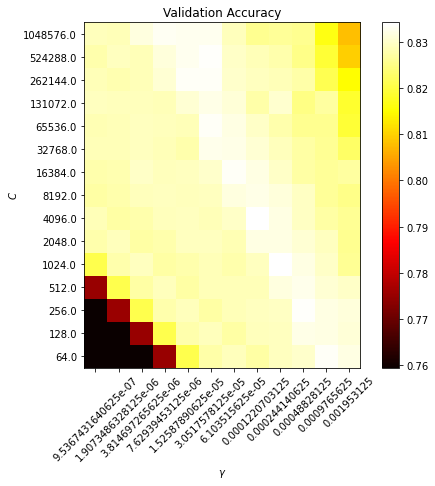

In [68]:
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, cmap=plt.cm.hot, origin='lower')
plt.xlabel('$\gamma$')
plt.ylabel('$C$')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation Accuracy')
plt.show()

We see that $C=2^{12}$ and $\gamma=2^{-13}$ provides the best performance out of the grid values tested, so we will fit our classifier with these values.  We set the `probability` parameter to `True` to allow the classifier to compute probabilities instead of just binary classification.

In [152]:
classifier = SVC(kernel='rbf', C=2**12, gamma=2**-13, probability=True, verbose=0)
classifier.fit(train_data, train_labels)

SVC(C=4096, gamma=0.0001220703125, probability=True, verbose=0)

The `predict_proba` method returns class probabilities based on input data.  To accomplish this, a technique called [Platt scaling](https://en.wikipedia.org/wiki/Platt_scaling) is employed.  Platt scaling runs a logistic regression model to transform the output of the SVM (or more generally, any classification model) into a probability distribution over classes.

Assuming the classification algorithm is given by a real-valued function $f$ with class predictions determined by $y=\text{sign}(f(x))$, Platt scaling obtains probabilities via $$\text{P}(y=1|x)=\frac1{1+\text{exp}(Af(x)+B)}$$ i.e., a logistic transformation on the classifier's scores.  Here, $A$ and $B$ are scalar parameters learned by the algorithm.  These parameters are estimated using a [maximum likelihood](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) method that optimizes on the same training set as that for the original classifier $f$.  Additionally, `sklearn` uses a [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) strategy to reduce overfitting.

In the case of an SVM with hyperplane coefficients $\beta$ and intercept $\beta_0$, $f$ is given by $$f(x)=\beta\cdot x+\beta_0.$$  This function is deployed in the `decision_function` method of the classifier class.

To transform the probailities into class predictions, we may simply apply thresholding on the probabilities.

In [153]:
pred_probs = classifier.predict_proba(valid_data)

thres = 0.5
pred_labels_from_proba = np.array([0 if prob[0] > thres else 1 for prob in pred_probs])

In [154]:
valid_acc = (valid_labels == pred_labels_from_proba).sum()/len(valid_labels)
print('Accuracy on validation data (via predict_proba): %.2f%%' % (100*valid_acc))

Accuracy on validation data (via predict_proba): 82.99%


As seen above, we have achieved a small improvement in performance by optimizing our $C$ and $\gamma$ values.

It is notable that the classifier's `predict` and `predict_proba` methods may be inconsistent. A sample may be labeled by `predict` as belonging to the positive class even if the output of `predict_proba` is less than 0.5; and similarly, it could be labeled as negative even if the output of `predict_proba` is more than 0.5.  This is due to the cross-validation approach used to train the logistic model for the probability estimation. The difference is usually minimal for large datasets, however, `predict` usually performs slightly better.

In [155]:
pred_labels = classifier.predict(valid_data)
valid_acc = (valid_labels == pred_labels).sum()/len(valid_labels)
print('Accuracy on validation data (via predict): %.2f%%' % (100*valid_acc))

Accuracy on validation data (via predict): 82.99%


In [156]:
diff = (pred_labels_from_proba != pred_labels).sum()/len(pred_labels)
print('Proportion of differing class labels between predict and predict_proba methods: %.2f%%' % (100*diff))

Proportion of differing class labels between predict and predict_proba methods: 0.07%


To check for overfitting, we can compare the above accuracy with the accuracy on the training data.

In [157]:
pred_labels_train = classifier.predict(train_data)
train_acc = (train_labels == pred_labels_train).sum()/len(train_labels)
print('Accuracy on training data %.2f%%' % (100*train_acc))

Accuracy on training data 82.69%


The similar accuracy on both datasets indicates the model is not overfitting the training dataset.

A confusion matrix will give us more insight into how well our model is performing.

In [158]:
cf_matrix = np.zeros((2,2))
for real, pred in zip(valid_labels.astype(int), pred_labels.astype(int)):
    cf_matrix[real][pred] += 1
    
print('Confusion matrix:')
pd.DataFrame(cf_matrix, index=['actual_<=50k', 'actual_>50k'], \
             columns=['predicted_<=50k', 'predicted_>50k']).astype(int)

Confusion matrix:


,predicted_<=50k,predicted_>50k
actual_<=50k,5779,448
actual_>50k,937,977


In [159]:
print('Normalized confusion matrix:')
pd.DataFrame(cf_matrix/cf_matrix.sum(), index=['actual_<=50k', 'actual_>50k'], \
             columns=['predicted_<=50k', 'predicted_>50k'])

Normalized confusion matrix:


,predicted_<=50k,predicted_>50k
actual_<=50k,0.709864,0.05503
actual_>50k,0.115096,0.12001


From the confusion matrix, we can calculate a few other metrics for evaluating out model.  First, we compute the misclassification rate, which is simply the fraction of predictions that were wrong.

In [160]:
misclass_rate = (cf_matrix[0][1]+cf_matrix[1][0])/cf_matrix.sum()
print('Misclassification rate: %.2f%%' % (100*misclass_rate))

Misclassification rate: 17.01%


We can also compute the recall, precision, and $F_1$ score.  Recall measures the proportion of actual positives that were identified correctly. That is, recall is defined as 

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives}+\text{False Negatives}}$$

Precision, on the other hand, is the proportion of positive identifications that were correct. Hence, precision is given by 

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives}+\text{False Positives}}$$

It is important to consider both these metrics when evaluating a classification model as it is possible to have high recall but low precision or vice versa.

$F_1$ score is a single metric which combines both the precision and recall.  It is given by the harmonic mean of precision and recall:

$$F_1=2\cdot\frac{\text{Recall}\cdot\text{Precision}}{\text{Recall}+\text{Precision}}$$

$F_1$ score is a useful metric since it is low if either precision or recall are low and allows us do sufficiently describe the effectiveness of our model in a single quantity.

In [161]:
recall = cf_matrix[1][1]/cf_matrix[1].sum()
print('Recall: ', recall)

precision = cf_matrix[1][1]/cf_matrix.sum(axis=0)[1]
print('Precision: ', precision)

f1 = 2*precision*recall/(precision + recall)
print('F1 score: ', f1)

Recall:  0.5104493207941484
Precision:  0.6856140350877193
F1 score:  0.5852051512428872


As with the logistic regression model in `IncomeViaLogisticRegression.ipynb`, our model has a greater precision than recall, and a decent $F_1$ score.

The ROC curve is a plot of the false positive rate on the horizontal axis versus the true positive rate on the vertical axis for thresholds varying from 0 to 1. It is particularly useful for directly comparing several models, however, for a single model, the area under the ROC curve (AUC) can be used as a summary of the model's effectiveness.

Here, we will load the predictions and validation labels from the logistic regression model created in `IncomeViaLogisticRegression.ipynb` to compute and compare the ROC curve.

In [162]:
from sklearn.metrics import roc_curve, roc_auc_score
import pickle

Accuracies:
  SVM: 82.99%
  Logistic Regression: 82.52%
F1 Scores:
  SVM: 0.585
  Logistic Regression: 0.599


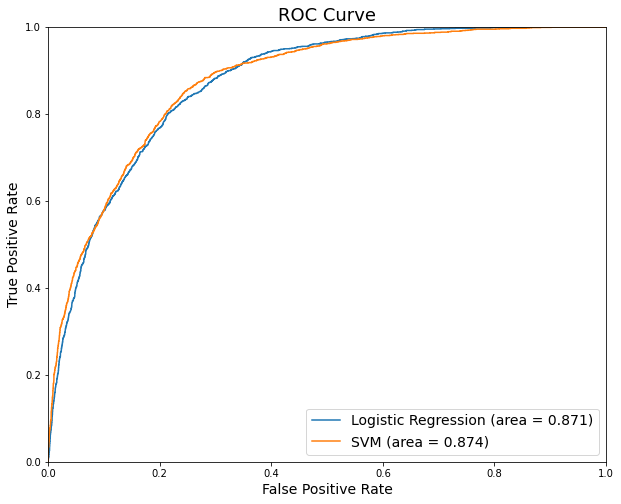

In [163]:
fpr, tpr, thresholds = roc_curve(valid_labels, pred_probs[:,1])
area = roc_auc_score(valid_labels, pred_probs[:,1])

with open('../Logistic Regression/income_and_predictions.pickle', 'rb') as f:
    valid_labels_lr, pred_probs_lr, valid_acc_lr, f1_lr = pickle.load(f)

fpr_lr, tpr_lr, thresholds_lr = roc_curve(valid_labels_lr, pred_probs_lr)
area_lr = roc_auc_score(valid_labels_lr, pred_probs_lr)

plt.figure(figsize=(10,8))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (area = %.3f)' % area_lr)
plt.plot(fpr, tpr, label='SVM (area = %.3f)' % area)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc='lower right', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=18)

print('Accuracies:\n  SVM: %.2f%%\n  Logistic Regression: %.2f%%' % (100*valid_acc, 100*valid_acc_lr))
print('F1 Scores:\n  SVM: %.3f\n  Logistic Regression: %.3f' % (f1, f1_lr))

The ROC curves for both models are very similar, with the SMV curve having a slightly higher AUC. This is consistent with the minimal difference we see in the accuracy and $F_1$ scores.  As the logistic regression model is computationally much simpler, it may prevail as the more practical model in many cases.